# Simulation Verification

Here, we check:
- The params and normalised params, as saved in the hypercube hdf5, are correctly indexed. Any shuffling would be catastrophic.
- What happens to the photometry as we fix all but one parameter, and vary that one parameter. Looks like everything has at least some impact, and we can tell ourselves stories about why they do what they do in terms of physics.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
from collections import OrderedDict
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')

from agnfinder import simulation_samples, simulation_utils

In [3]:
os.chdir('/home/mike/repos/agnfinder')

In [4]:
def load_grid(grid_loc):
    assert os.path.isfile(grid_loc)
    with h5py.File(grid_loc, 'r') as f:
        param_names = f['samples']['theta'].attrs['columns']  # stored as "attribute" metadata
        norm_theta = f['samples']['normalised_theta'][...]
        theta = f['samples']['theta'][...]
        simulated_y = f['samples']['simulated_y'][...]
        wavelengths = f['samples']['wavelengths'][...]
    return param_names, norm_theta, theta, simulated_y, wavelengths

### Old - for a single cube output

In [7]:
grid_loc = 'data/cubes/photometry_simulation_10000n_z_0p3000_to_0p7000.hdf5'
param_names, norm_theta, theta, simulated_y, wavelengths = load_grid(grid_loc)

In [8]:
simulated_y

array([[5.69770989e-08, 5.48790057e-08, 7.45193755e-08, ...,
        1.37972707e-07, 8.84261016e-07, 1.24274101e-06],
       [1.52485925e-10, 3.37482933e-10, 1.07393212e-09, ...,
        2.43796846e-09, 8.20306550e-09, 8.18937079e-09],
       [2.23372964e-07, 5.05316210e-07, 5.90415822e-07, ...,
        7.14067546e-07, 1.15142385e-07, 7.48042269e-08],
       ...,
       [2.84482478e-11, 9.46657819e-11, 3.80073400e-10, ...,
        1.69666995e-09, 2.13048668e-07, 2.61088645e-07],
       [4.62441649e-12, 7.81812566e-12, 2.34835317e-11, ...,
        4.80112004e-11, 6.76914590e-11, 4.85954507e-11],
       [1.90310556e-11, 4.62488515e-11, 6.17824608e-11, ...,
        1.01091181e-10, 1.40399695e-09, 1.99909218e-09]])

In [9]:
theta

array([[6.86951340e-01, 6.19326520e+11, 1.00778647e-01, ...,
        3.20709071e-07, 2.09559630e-01, 2.76225443e-02],
       [3.43942745e-01, 1.94220644e+10, 1.46053244e+00, ...,
        9.81929344e-05, 4.10667717e-01, 3.92540570e-07],
       [6.55199718e-01, 5.73208921e+11, 7.25317512e-01, ...,
        1.94690528e-01, 3.41874812e-01, 7.23925133e-04],
       ...,
       [3.68421199e-01, 6.14421725e+09, 1.35955707e+00, ...,
        6.74359757e-07, 1.86360644e-02, 1.62373591e-01],
       [3.18099422e-01, 2.60873864e+08, 1.76751696e-02, ...,
        1.30062466e-04, 1.35184179e-02, 2.16847484e-07],
       [5.65413348e-01, 4.85234850e+08, 1.04866057e+00, ...,
        2.34015904e-02, 4.58493268e-01, 3.85130968e-02]])

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,  999.,
        1001.]),
 array([0.07500103, 0.08500044, 0.09499984, 0.10499924, 0.11499864,
        0.12499805, 0.13499745, 0.14499685, 0.15499626, 0.16499566,
        0.17499506]),
 <a list of 10 Patch objects>)

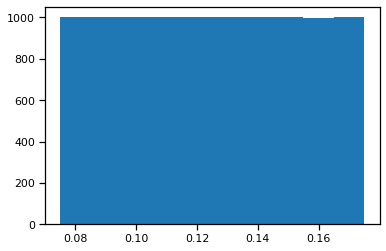

In [11]:
plt.hist(norm_theta[:, 0])

### New - for many redshift slice cubes

In [12]:

grid_locs = glob.glob('data/cubes/photometry_simulation_10000n_*.hdf5')
assert grid_locs

norm_theta_list = []
theta_list = []
simulated_y_list = []
wavelengths_list = []

for grid_loc in grid_locs:
    param_names, norm_theta, theta, simulated_y, wavelengths = load_grid(grid_loc)
    norm_theta_list.append(norm_theta)
    theta_list.append(theta)
    simulated_y_list.append(simulated_y)
    wavelengths_list.append(wavelengths)

In [13]:
norm_theta = np.concatenate(norm_theta_list, axis=0)
theta = np.concatenate(theta_list, axis=0)
simulated_y = np.concatenate(simulated_y_list, axis=0)

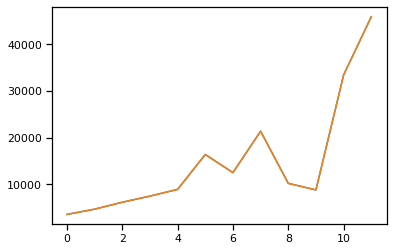

In [14]:
plt.plot(np.array(wavelengths_list).transpose())  # exactly the same, as hoped - rest frame wavelengths?

## Visualise theta vs normalised theta

In [15]:
param_names

array(['redshift', 'log_mass', 'dust2', 'tage', 'log_tau', 'log_agn_mass',
       'agn_eb_v', 'log_agn_torus_mass'], dtype=object)

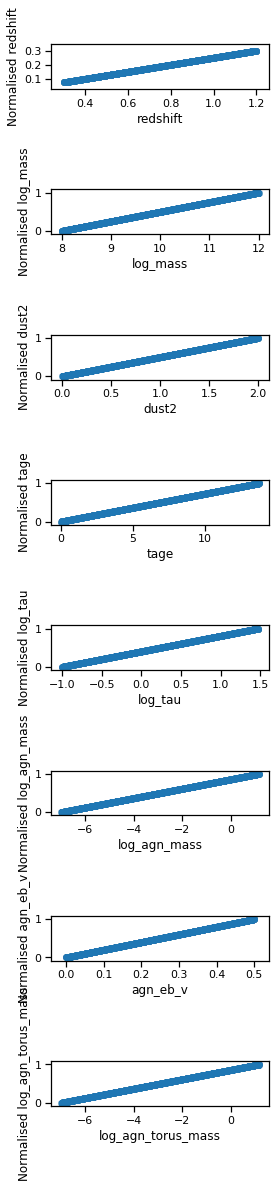

In [16]:
fig, axes = plt.subplots(nrows=len(param_names), figsize=(4, 16))
for param_n, param_name in enumerate(param_names):
    if param_name.startswith('log'):
        theta_to_plot = np.log10(theta)
    else:
        theta_to_plot = theta
    ax = axes[param_n]
    ax.scatter(theta_to_plot[:, param_n], norm_theta[:, param_n], alpha=0.03)
    ax.set_xlabel(param_name)
    ax.set_ylabel(f'Normalised {param_name}')
fig.tight_layout()

## Visualise photometry in grid along each param

In [18]:
wavelengths  # in angstroms

array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])

#### Random selection of galaxies

In [19]:
n_traces = 100

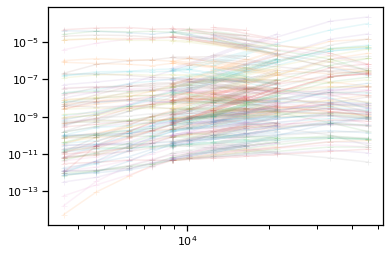

In [20]:
fig, ax = plt.subplots()
selected_indices = np.random.choice(np.arange(len(simulated_y)), size=n_traces)
selected_photometry = simulated_y[selected_indices]
for n in range(n_traces):  # first n
    ax.loglog(wavelengths, selected_photometry[n], marker='+', alpha=0.1)


### Coloring by one parameter

In [31]:
selection_mask = (theta[:, 5] < 10 ** -2) & (theta[:, 7] < 10 ** -2)  # only galaxies without AGN
theta_selected = theta[selection_mask]
norm_theta_selected = norm_theta[selection_mask]
photometry_selected = simulated_y[selection_mask]

In [32]:
n_traces = 100
param_n = 0
sample_indices = np.random.choice(np.array(range(len(theta_selected))), size=n_traces)

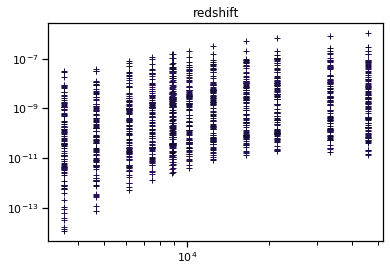

In [33]:
fig, ax = plt.subplots()
param_n = 0  # log mass
for n in range(n_traces):
    ax.loglog(wavelengths, photometry_selected[n], marker='+', color=cm.magma(norm_theta_selected[n, param_n]), linestyle='')
    ax.set_title(param_names[param_n])

In [34]:
# selection_mask = (norm_theta_selected[:, 0] > 0.4) & (norm_theta_selected[:, 0] < 0.6)  # fix the mass
# photometry_fixed_mass = photometry_selected[selection_mask]
# theta_fixed_mass = theta_selected[selection_mask]
# norm_theta_fixed_mass = norm_theta_selected[selection_mask]

In [35]:
# n_galaxy_params = 4
# fig, axes = plt.subplots(nrows=n_galaxy_params-1, figsize=(6, 14))
# n_traces = 10
# for param_n in range(1, n_galaxy_params):
#     for n in range(n_traces):
#         ax = axes[param_n-1]
#         ax.loglog(wavelengths, photometry_fixed_mass[n], marker='+', color=cm.magma(norm_theta_fixed_mass[n, param_n]), linestyle='')
#         ax.set_title(param_names[param_n])
# fig.tight_layout()

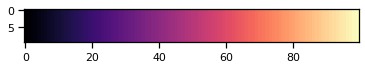

In [36]:
plt.imshow([np.linspace(0, 1, 100) for n in range(10)], cmap=cm.magma)
# plt.xticks(np.linspace(0, 1, 100))

772
74
9


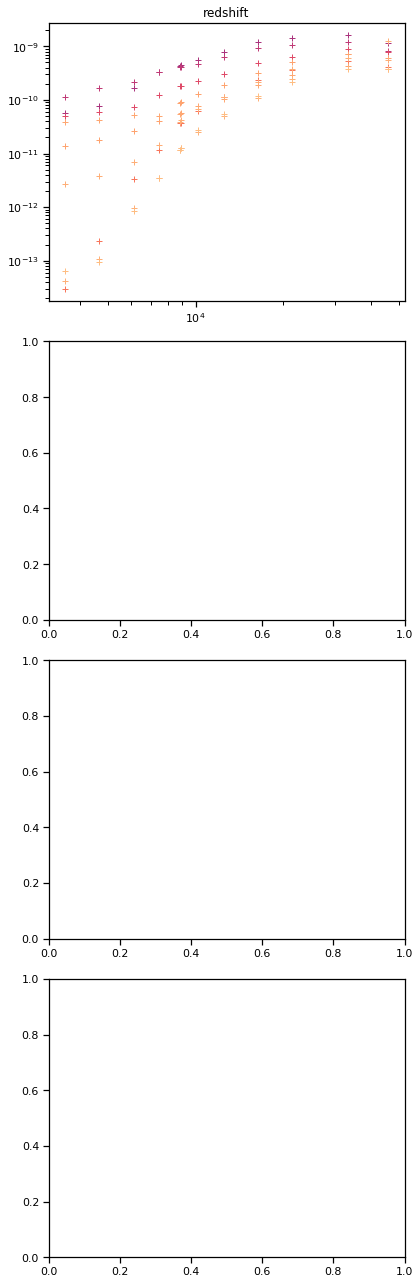

In [42]:
# really though, we want to fix *everything else*
n_galaxy_params = 4
fig, axes = plt.subplots(nrows=n_galaxy_params, figsize=(6, 18))
n_traces = 25
# for param_n in range(n_galaxy_params):
for param_n in range(1):
    selection_mask = np.ones(len(photometry_selected)).astype(bool)
    for n in range(n_galaxy_params):
        if n is not param_n:
            new_filter = np.array([(norm_theta_selected[:, n] > 0.45) & (norm_theta_selected[:, n] < 0.55)]).squeeze()
            selection_mask = selection_mask & new_filter
            print(selection_mask.sum())
    assert selection_mask.any()
    photometry_else_fixed = photometry_selected[selection_mask]
    norm_theta_else_fixed = norm_theta_selected[selection_mask]
    for n in range(min(n_traces, len(photometry_else_fixed))):
        ax = axes[param_n]
#         ax.loglog(wavelengths, photometry_else_fixed[n], marker='+', color=cm.magma(norm_theta_else_fixed[n, param_n]), linestyle='')
        ax.loglog(wavelengths, photometry_else_fixed[n], marker='+', color=cm.magma(norm_theta_else_fixed[n, param_n] * 3.), linestyle='')
        ax.set_title(param_names[param_n])
    fig.tight_layout()

In [40]:
norm_theta_else_fixed[:, 0]

array([0.15721855, 0.23782127, 0.2713435 , 0.17559471, 0.27839438,
       0.20177891, 0.26886625, 0.27638925, 0.2870035 ])

In [ ]:
assert False

In [ ]:
galaxy_index = 10

In [ ]:
direct_simulator, wavelengths = simulation_samples.get_photometry_simulator(
        emulate_ssp=True,
        noise=True)

In [ ]:
direct_photometry = direct_simulator(theta[galaxy_index])

In [ ]:
wavelengths

In [ ]:
sims = np.array([simulated_y[n] for n in range(100)])
assert np.argmin(np.sum(np.abs(sims - direct_photometry), axis=1)) == galaxy_index

In [ ]:
plt.loglog(wavelengths, sims[galaxy_index], 'x', label='stored')
plt.loglog(wavelengths, direct_photometry, 'x', label='recovered')
plt.legend() # also matches indirect (i.e. via normalisasimulate(args.n_samples, save_loc, args.emulate_ssp, args.noise)tion)

In [ ]:
limits = OrderedDict({
            'log_mass': [8, 12], 
            'dust2': [0.001, 13.8],
            'tage': [0., 2.],
            'tau': [.1, 30],
            'log_agn_mass': [-7, np.log10(15)],
            'agn_eb_v': [0., 0.5],
            'log_agn_torus_mass': [-7, np.log10(15)]
        })

simulation_utils.denormalise_theta(norm_theta[0], limits)

In [ ]:
problem = main.load_simulator(emulate_ssp=True, noise=False)

In [ ]:
10 ** problem.simulator(norm_theta[0])